In [1]:
space = dict()
space['subsample'] = [0.25, 0.5, 0.75, 1.0] # row sampling
space['colsample_bytree'] = [0.25, 0.5, 0.75, 1.0] # column sampling
space['colsample_bylevel'] = [0.25, 0.5, 0.75, 1.0] # column sampling at each split
space['eta'] = [0.1, 0.2, 0.3] # Learning rate

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier
import pickle
from zmq import device


def tune_xgboost(X, y, space, n_estimators=500, balance=False):
    # define evaluation
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scoring = 'roc_auc'
    # TODO : discuss if this is the best metric, ('accuracy', 'roc_auc', 'f1', 'precision', 'recall')

    # find total negative and positive samples 
    total = len(y)
    total_positive = np.sum(y==1)
    total_negative = total - total_positive
    
    # TODO: discuss if it makes sense to train with this parameter for unbalanced dataset 
    # could be that in the future there is another inbalance

    # set the scale pos weight
    scale_pos_weight = total_negative / total_positive if balance else 1

    # print total positive % and total negative %, and scale pos weight (all rounded)
    print(f'Total positive : {round(100*(total_positive/total), 3)}%')
    print(f'Total negative : {round(100*(total_negative/total), 3)}%')
    print(f'Scale pos weight: {round(scale_pos_weight, 3)}')

    # define the model
    model = XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=n_estimators, device='cuda', n_jobs=-1)
    # define search
    search = GridSearchCV(model, space, scoring=scoring, n_jobs=-1, cv=cv)
    # execute search
    result = search.fit(X, y)
    
    # plot results
    results_df = pd.DataFrame(result.cv_results_)
    for key, values in space.items():
        
        # group the results by the hyperparameter
        param_means = []
        param_stds = []
        for value in values:
            mask = results_df['param_' + key] == value
            param_means.append(np.mean(results_df[mask]['mean_test_score']))
            param_stds.append(np.std(results_df[mask]['mean_test_score']))

        # create plot with two subplots side by side
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))
        fig.suptitle(key)
        ax[0].plot(values, param_means)
        ax[0].set_title('Mean test scores')
        ax[0].set_xlabel(key)
        ax[0].set_ylabel('mean scores')
        padding = 0.1
        ax[0].set_ylim(max(0, min(param_means) - padding), min(1, max(param_means) + padding))

        ax[1].plot(values, param_stds)
        ax[1].set_title('Mean score std')
        ax[1].set_xlabel(key)
        ax[1].set_ylabel('score std')
        padding = 0.05
        ax[1].set_ylim(max(0, min(param_stds) - padding), min(1, max(param_stds) + padding))

        plt.show()

    # summarize result
    print('Best Score: %s' % result.best_score_)
    print('Best Hyperparameters:')
    for k, v in result.best_params_.items():
        print('%s: %s' % (k, v))

    # best model
    best_model = result.best_estimator_

    return result.best_params_, best_model

In [3]:
# import data
data = pd.read_csv('../../data/datasetlabel.csv')
data['date'] = pd.to_datetime(data['date'])

# load selected features with pickle
with open('../../data/selected_features.pkl', 'rb') as f:
    selected_features = pickle.load(f)

In [5]:
start_date = pd.to_datetime('2008-01-01')
end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
training_features = selected_features[start_date]

# print the features
print(f'Training features:\n{training_features}')

X = training_data[training_features].copy()
y = training_data['target'].copy()
negative_mask = (y == -1)
y[negative_mask] = 0

Training features:
['CAPEI', 'equity_invcap', 'evm', 'pe_op_basic', 'pe_inc', 'ps', 'ptpm', 'roa', 'roe', 'aftret_equity', 'aftret_invcapx', 'GProf', 'capital_ratio', 'short_debt', 'fcf_ocf', 'lt_ppent', 'at_turn', 'rect_turn', 'pay_turn', 'adv_sale', 'stat_divyeld', 'prc', 'vol', 'retx', 'mktcap', 'MACD_index']


Total positive : 42.712%
Total negative : 57.288%
Scale pos weight: 1


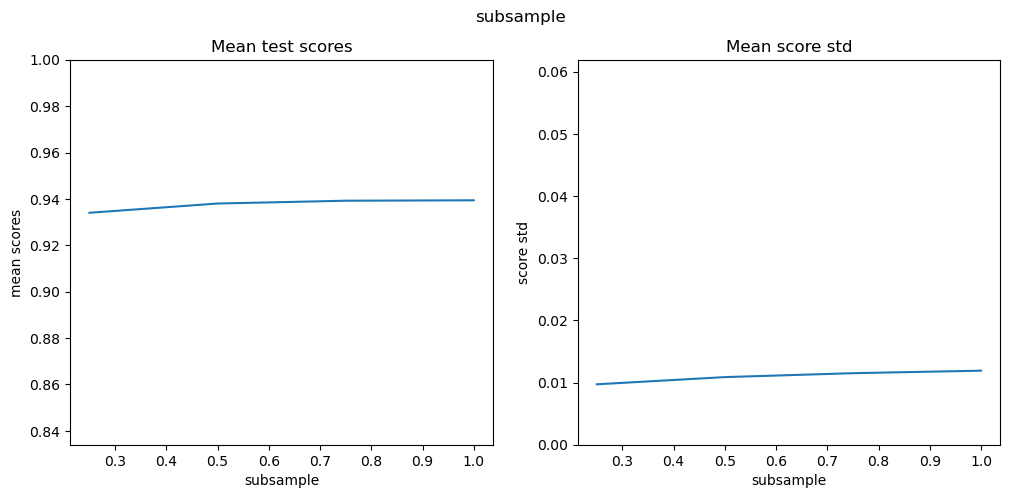

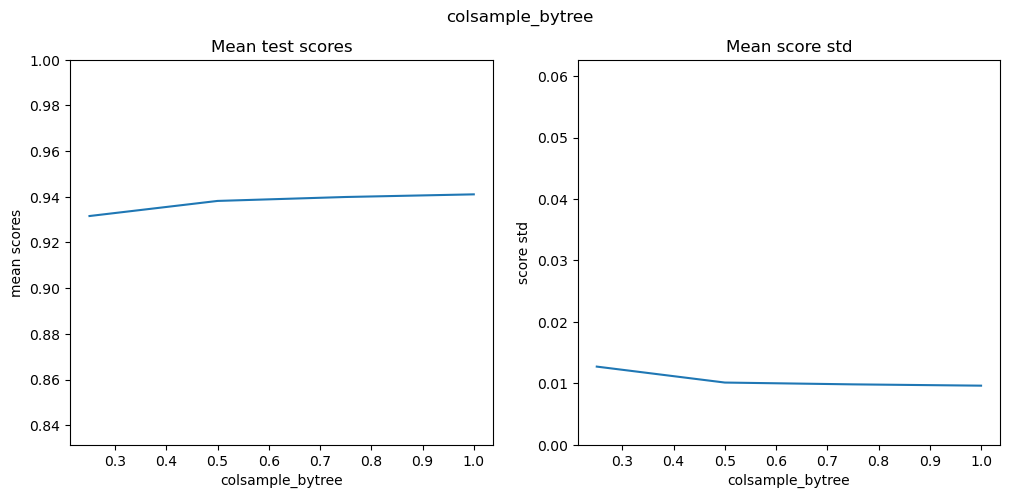

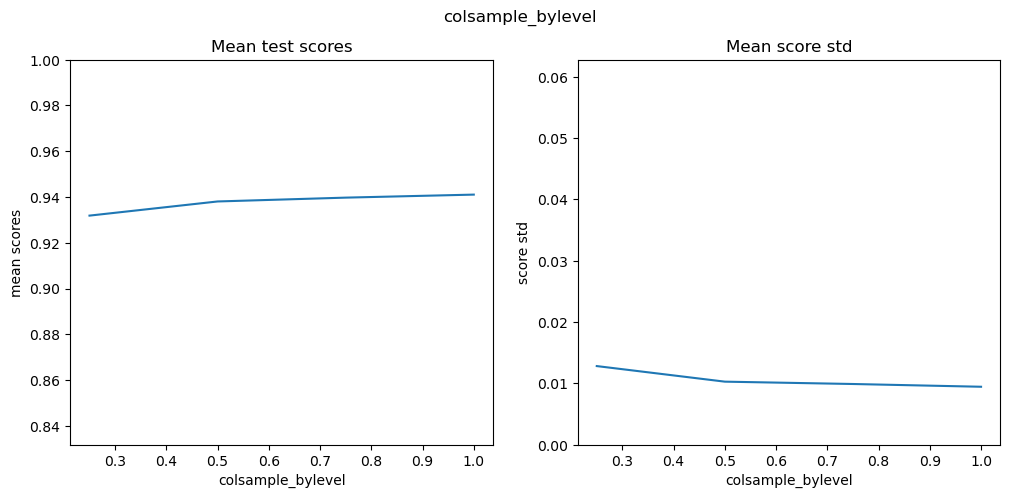

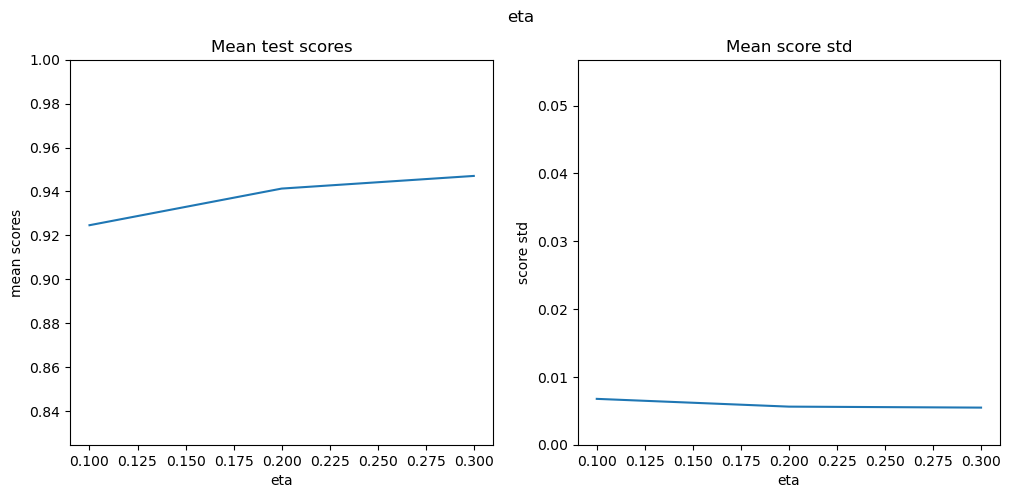

Best Score: 0.9546830062429325
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
eta: 0.3
subsample: 1.0


In [7]:
space = dict()
space['subsample'] = [0.25, 0.5, 0.75, 1.0] # row sampling
space['colsample_bytree'] = [0.25, 0.5, 0.75, 1.0] # column sampling
space['colsample_bylevel'] = [0.25, 0.5, 0.75, 1.0] # column sampling at each split
space['eta'] = [0.1, 0.2, 0.3] # Learning rate

n_estimators = 300

best_parameters, best_model = tune_xgboost(X, y, space, n_estimators=n_estimators, balance=False)

In [8]:
# create name of the best model with n_estimators and start date
start_date_str = start_date.strftime('%Y-%m-%d')
model_name = f'xg_boost_{start_date_str}_{n_estimators}'

# save the model
with open(f'../../models/{model_name}.pkl', 'wb') as f:
    pickle.dump(best_model, f)

In [17]:
first_time = list(selected_features.keys())[0]

Training model for 2010-01-01
Training features:
['CAPEI', 'npm', 'debt_ebitda', 'pe_op_dil', 'pe_exi', 'rd_sale', 'pcf', 'opmbd', 'roce', 'aftret_equity', 'adv_sale', 'cash_lt', 'debt_at', 'debt_assets', 'short_debt', 'fcf_ocf', 'dltt_be', 'de_ratio', 'sale_invcap', 'rect_turn', 'pay_turn', 'stat_divyeld', 'prc', 'vol', 'retx', 'prc_adj']
Total positive : 61.58%
Total negative : 38.42%
Scale pos weight: 0.624


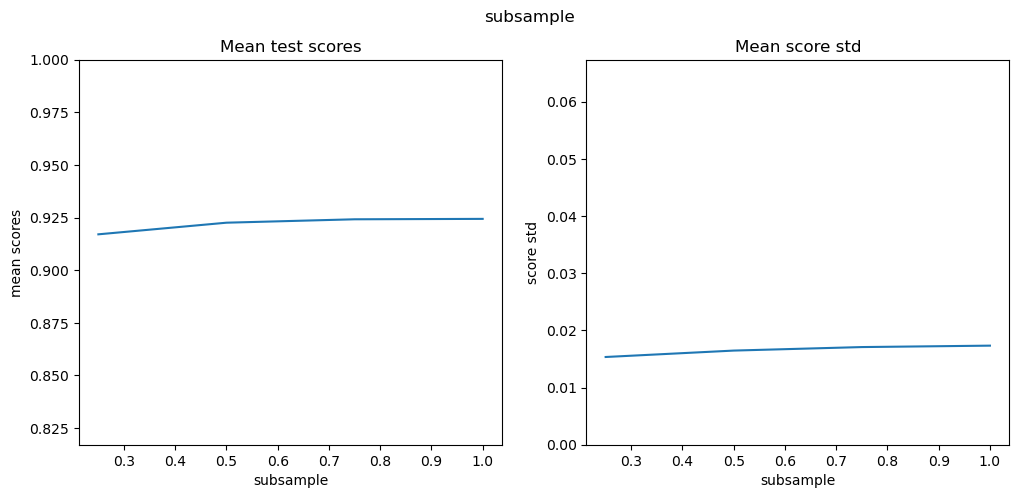

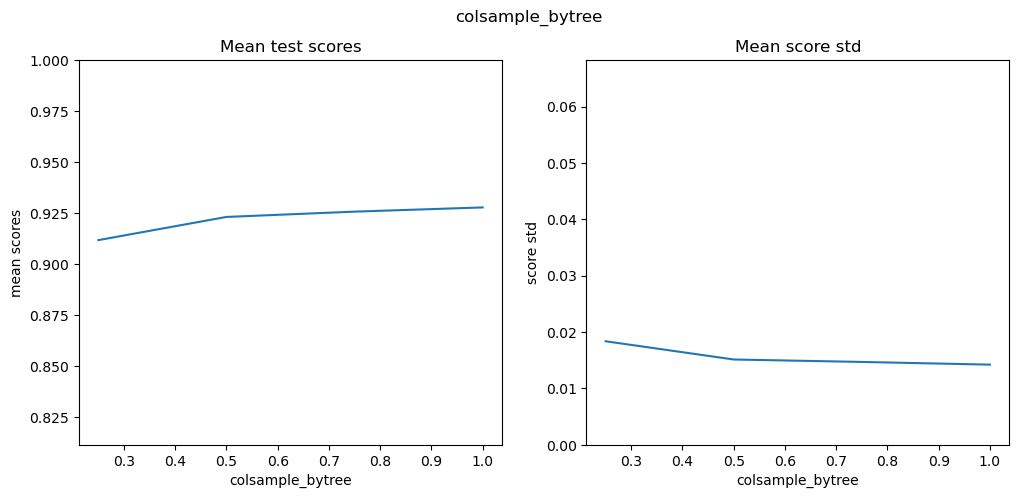

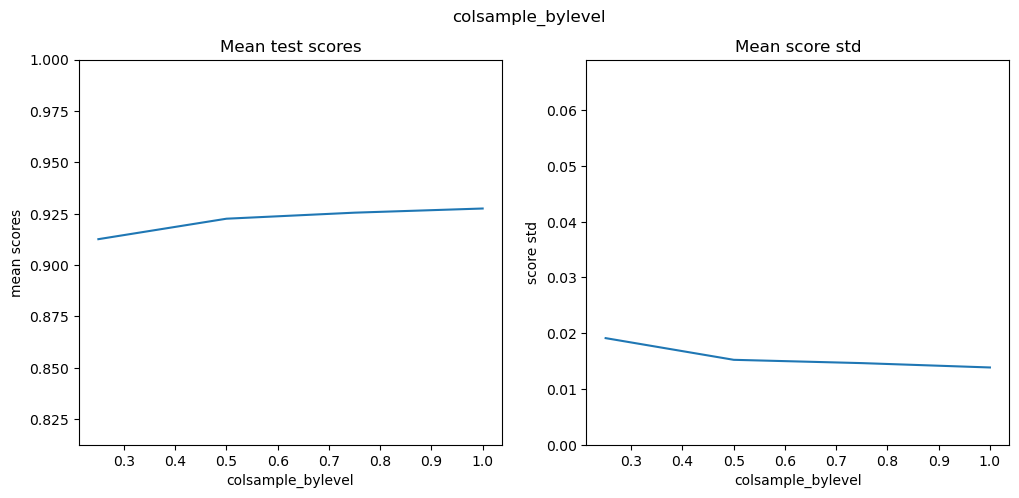

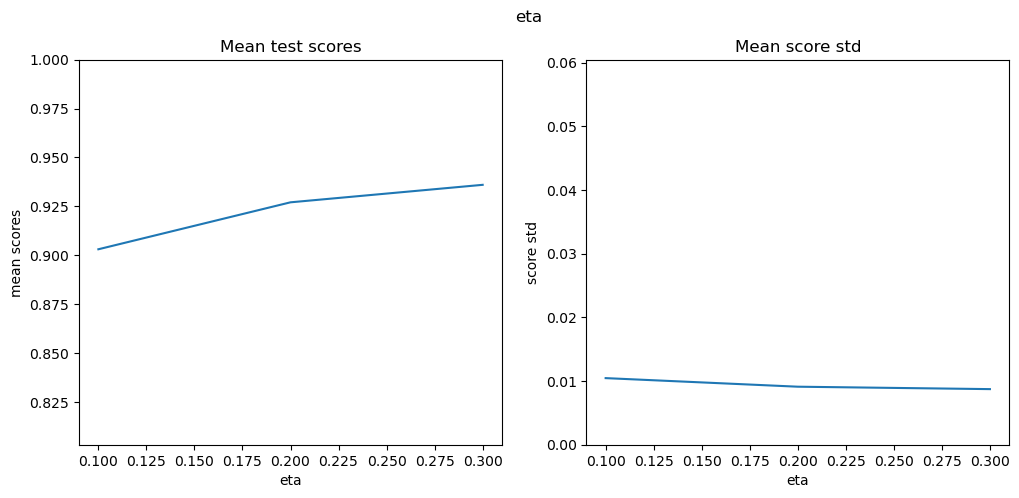

Best Score: 0.9474103869393466
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
eta: 0.3
subsample: 1.0
Model saved as xg_boost_2010-01-01_300.pkl
----------------------

Training model for 2012-01-01
Training features:
['CAPEI', 'opmbd', 'debt_ebitda', 'pe_op_basic', 'pe_inc', 'ps', 'pcf', 'ptpm', 'roa', 'totdebt_invcap', 'aftret_equity', 'cash_debt', 'debt_at', 'fcf_ocf', 'sale_equity', 'at_turn', 'rect_turn', 'pay_turn', 'adv_sale', 'accrual', 'stat_divyeld', 'prc', 'vol', 'retx', 'MACD_index']
Total positive : 69.655%
Total negative : 30.345%
Scale pos weight: 0.436


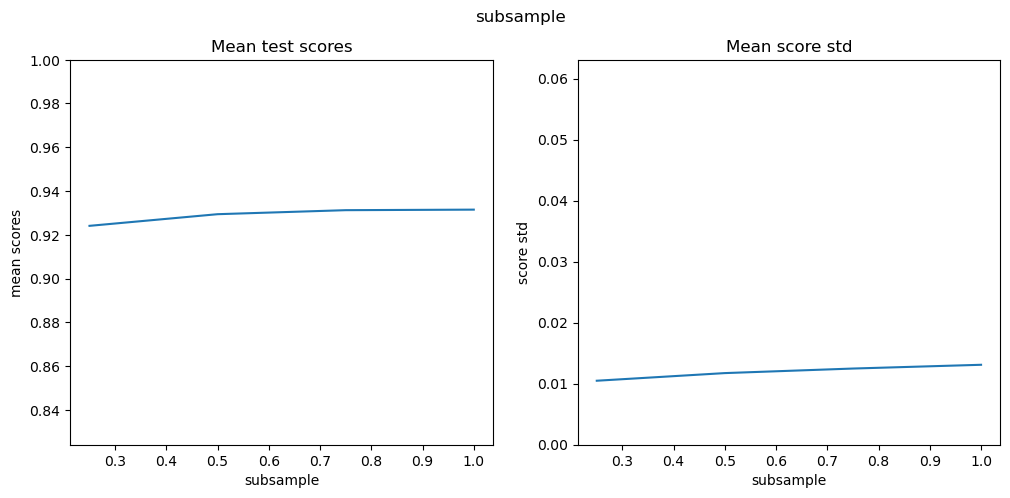

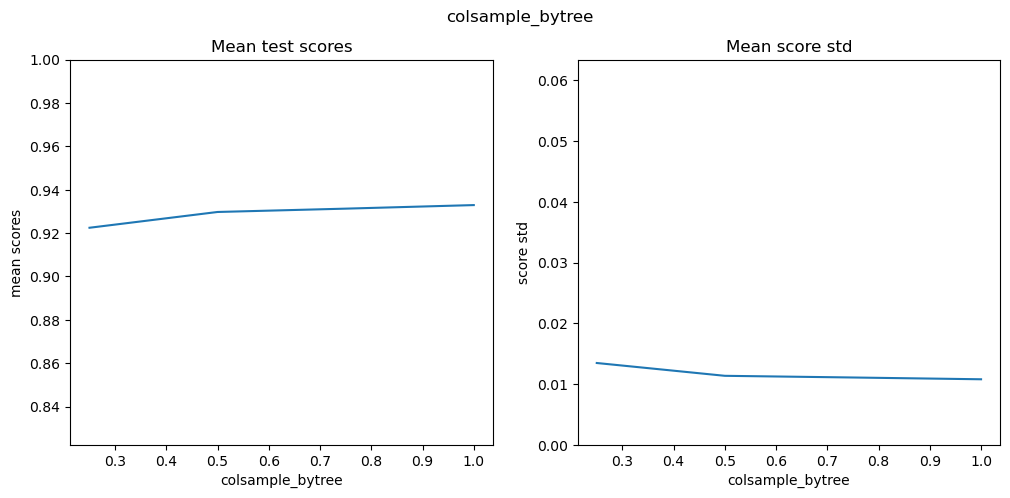

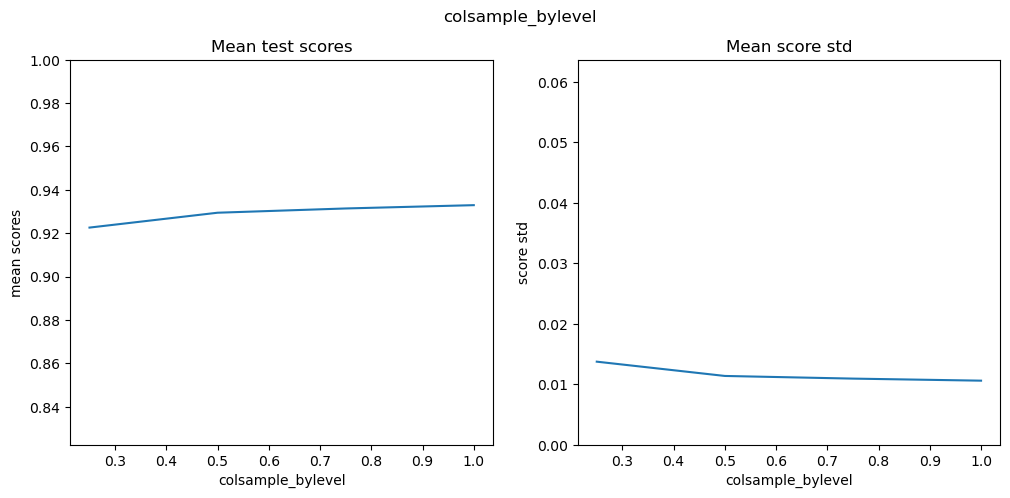

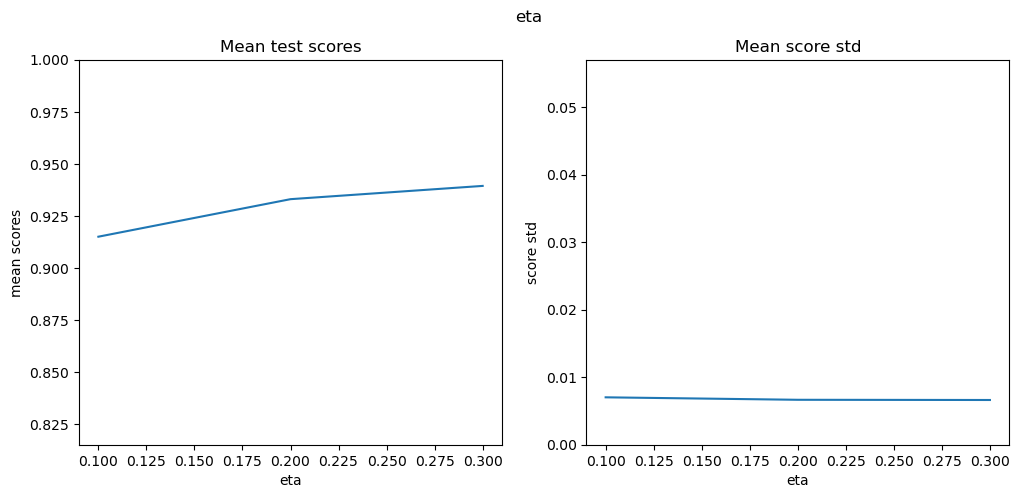

Best Score: 0.9486646573828641
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
eta: 0.3
subsample: 1.0
Model saved as xg_boost_2012-01-01_300.pkl
----------------------

Training model for 2014-01-01
Training features:
['CAPEI', 'bm', 'evm', 'pe_op_dil', 'pe_inc', 'cash_lt', 'ptb', 'npm', 'opmad', 'roa', 'aftret_eq', 'debt_capital', 'lt_debt', 'fcf_ocf', 'de_ratio', 'sale_invcap', 'rect_turn', 'pay_turn', 'adv_sale', 'divyield', 'prc_adj', 'vol', 'retx', 'mktcap', 'MACD_index']
Total positive : 60.916%
Total negative : 39.084%
Scale pos weight: 0.642


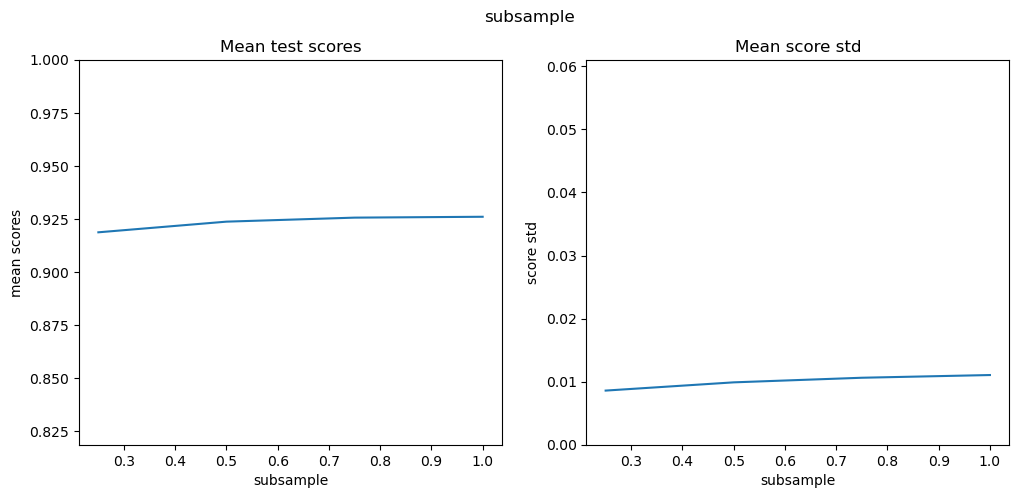

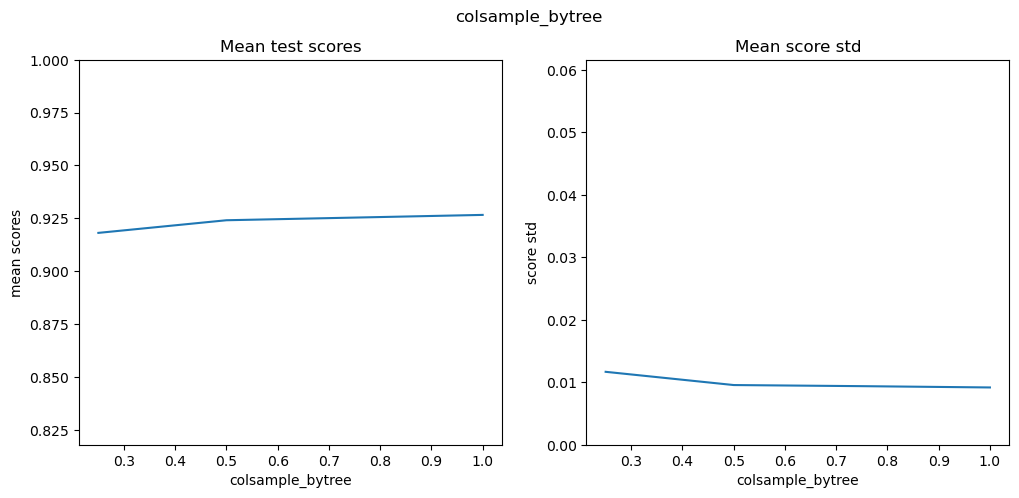

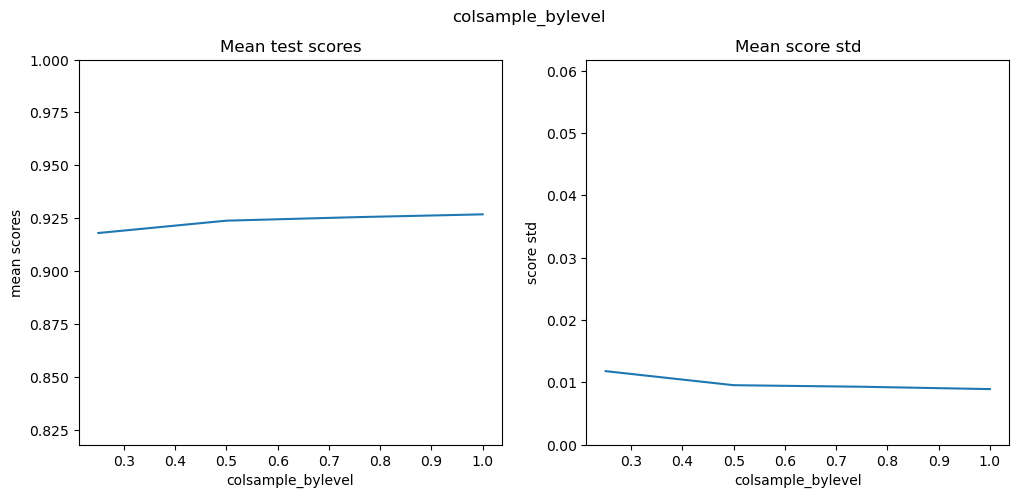

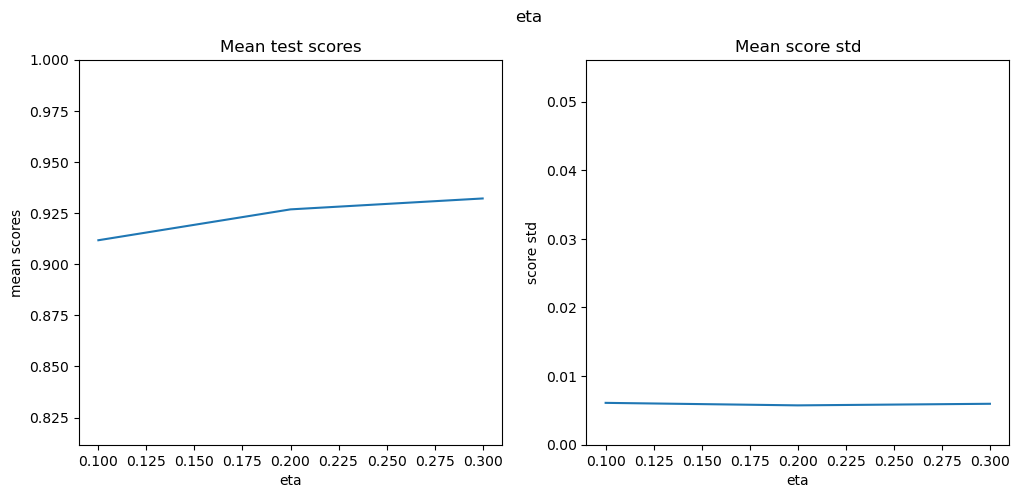

Best Score: 0.9409626379138575
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
eta: 0.3
subsample: 1.0
Model saved as xg_boost_2014-01-01_300.pkl
----------------------

Training model for 2016-01-01
Training features:
['CAPEI', 'bm', 'evm', 'pe_op_dil', 'pe_inc', 'ps', 'npm', 'opmbd', 'roa', 'dltt_be', 'aftret_equity', 'lt_ppent', 'debt_invcap', 'fcf_ocf', 'de_ratio', 'at_turn', 'rect_turn', 'pay_turn', 'adv_sale', 'divyield', 'prc', 'vol', 'ret', 'mktcap', 'rsi']
Total positive : 62.175%
Total negative : 37.825%
Scale pos weight: 0.608


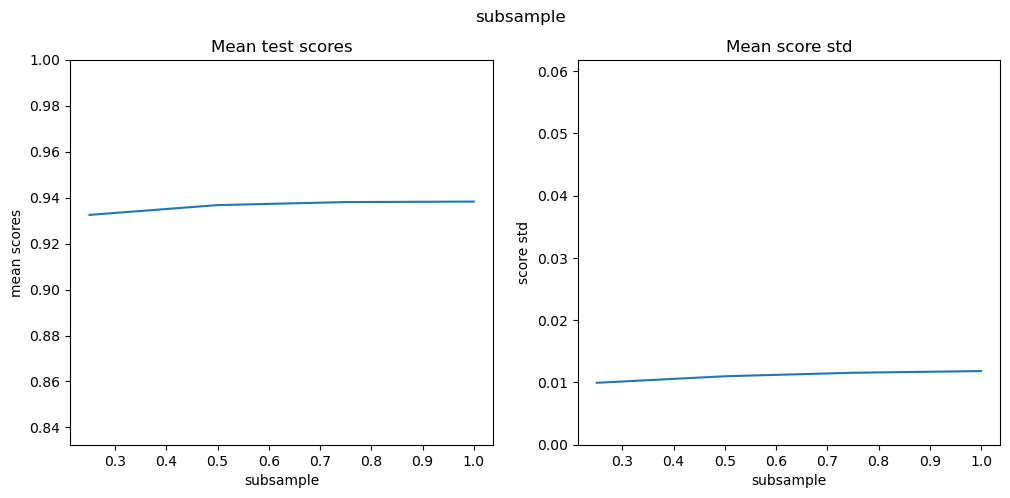

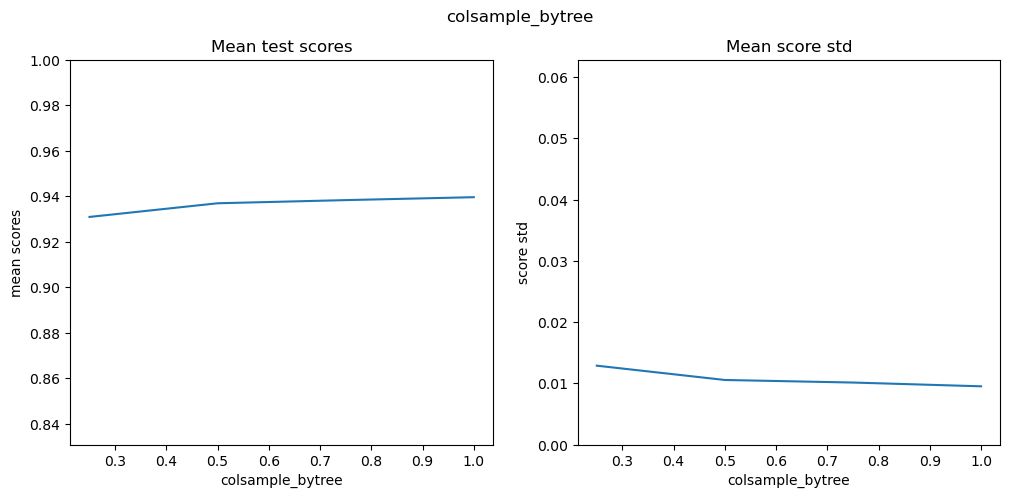

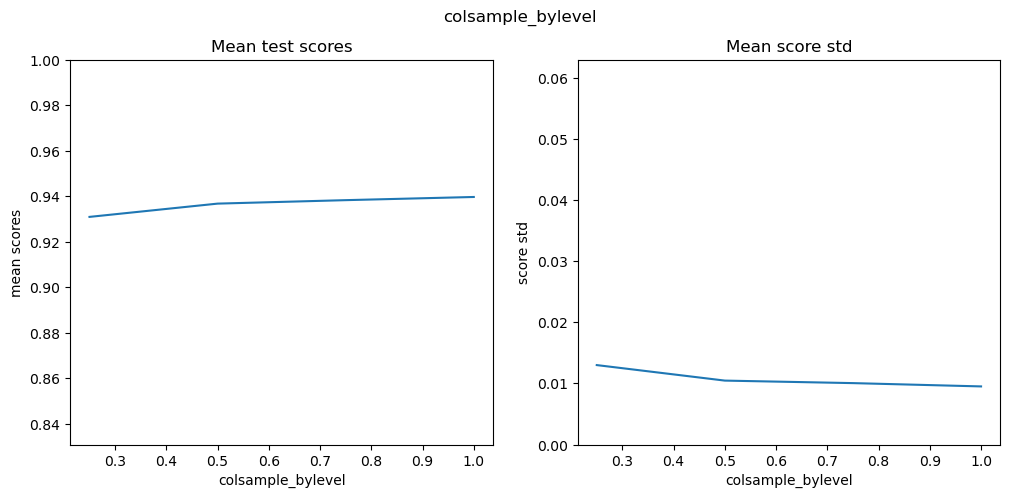

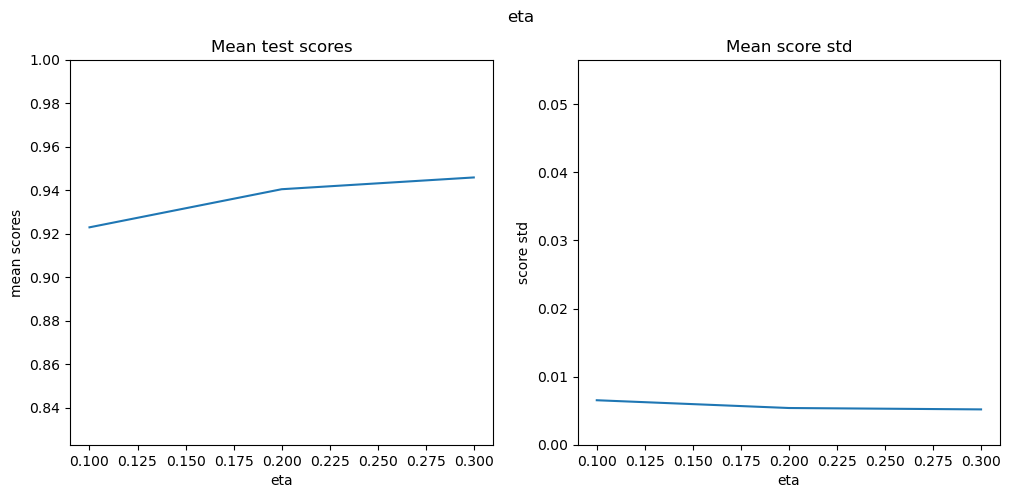

Best Score: 0.9525963180766709
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
eta: 0.3
subsample: 1.0
Model saved as xg_boost_2016-01-01_300.pkl
----------------------

Training model for 2018-01-01
Training features:
['CAPEI', 'bm', 'evm', 'pe_op_dil', 'pe_inc', 'cash_lt', 'ptb', 'ptpm', 'opmbd', 'aftret_invcapx', 'aftret_eq', 'at_turn', 'debt_capital', 'lt_debt', 'short_debt', 'fcf_ocf', 'de_ratio', 'rect_turn', 'pay_turn', 'adv_sale', 'divyield', 'prc', 'vol', 'ret', 'mktcap', 'rsi']
Total positive : 55.311%
Total negative : 44.689%
Scale pos weight: 0.808


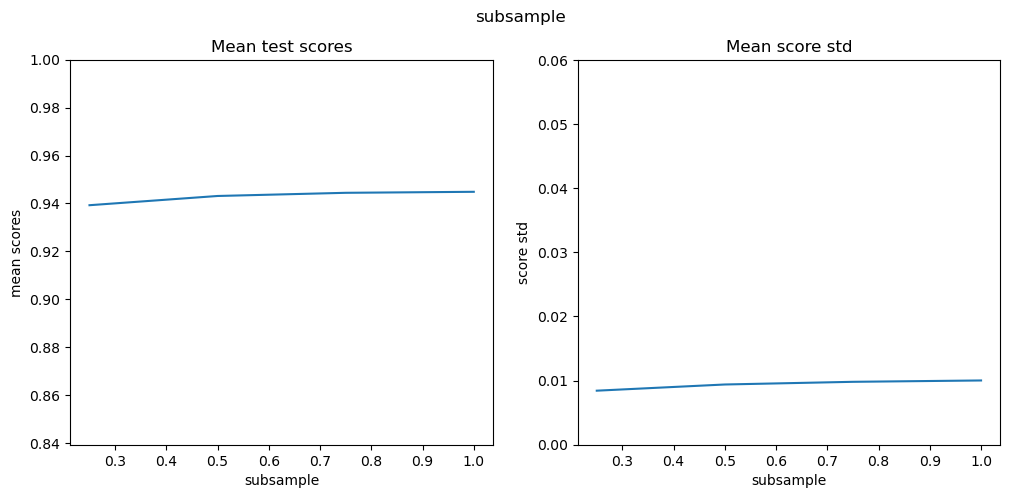

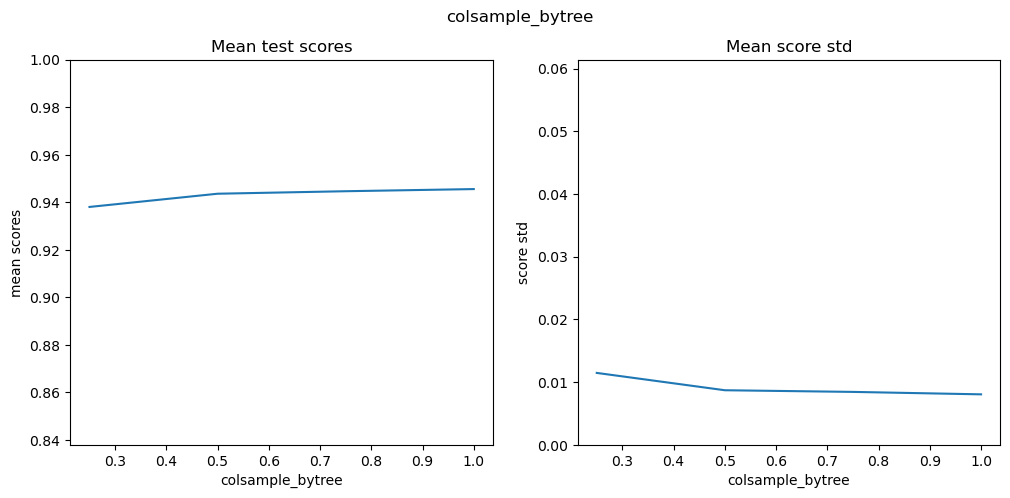

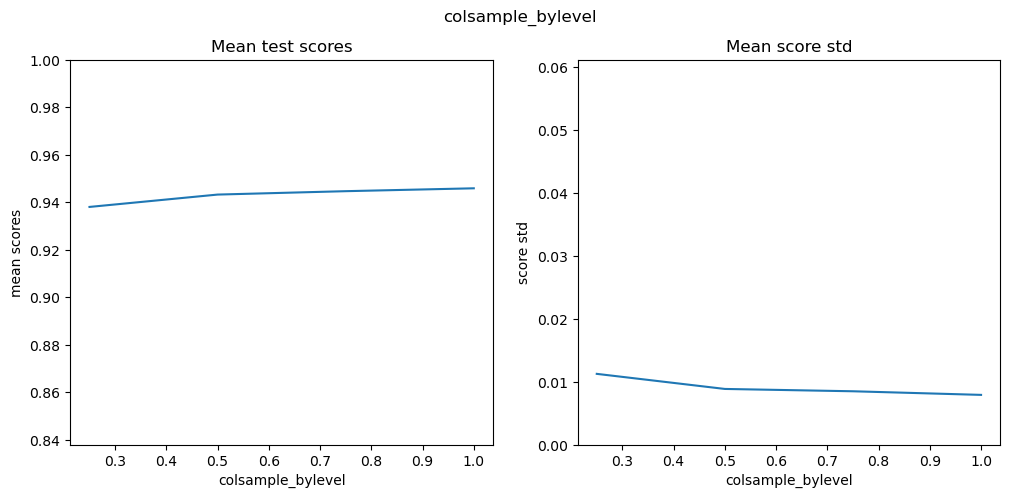

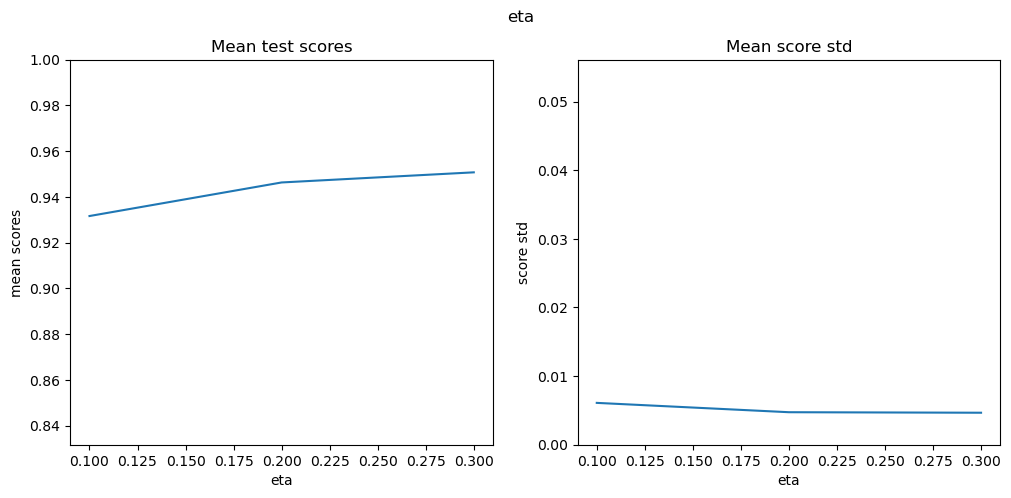

Best Score: 0.9569223541521055
Best Hyperparameters:
colsample_bylevel: 1.0
colsample_bytree: 1.0
eta: 0.3
subsample: 1.0
Model saved as xg_boost_2018-01-01_300.pkl
----------------------



In [20]:
space = dict()
space['subsample'] = [0.25, 0.5, 0.75, 1.0] # row sampling
space['colsample_bytree'] = [0.25, 0.5, 0.75, 1.0] # column sampling
space['colsample_bylevel'] = [0.25, 0.5, 0.75, 1.0] # column sampling at each split
space['eta'] = [0.1, 0.2, 0.3] # Learning rate

n_estimators = 300

for year in selected_features:
    if year > first_time:
        start_date = pd.to_datetime(year)
        end_date = start_date + pd.DateOffset(years=2) - pd.DateOffset(days=91)

        training_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]
        training_features = selected_features[start_date]

        # print the features
        print(f'Training model for {start_date.strftime("%Y-%m-%d")}')
        print(f'Training features:\n{training_features}')

        X = training_data[training_features].copy()
        y = training_data['target'].copy()
        negative_mask = (y == -1)
        y[negative_mask] = 0

        best_parameters, best_model = tune_xgboost(X, y, space, n_estimators=n_estimators, balance=True)
        start_date_str = start_date.strftime('%Y-%m-%d')
        model_name = f'xg_boost_{start_date_str}_{n_estimators}'

        # save the model
        with open(f'../../models/{model_name}.pkl', 'wb') as f:
            pickle.dump(best_model, f)
        print(f'Model saved as {model_name}.pkl')
        print('----------------------\n')
    